# RAG from Scratch in PyTorch
* Notebook by Adam Lang
* Date: 7/8/2024

# Overview
* This framework is adopted from a webinar session with Mr. Daniel Bourke a well known Machine Learning Engineer and creator of the Udemy-ZTM course "PyTorch with Deep Learning Bootcamp".
* This notebook will build a RAG-LLM application "from scratch" but WITHOUT using an API connector like LangChain.
* We will use the following:
1. Open source `google/gemma-2b-it` model from huggingface.
2. SentenceTransformers for embeddings.
3. HuggingFace open source LLM universal functions for instruction-tuned models.
4. PyTorch
* A "typical" RAG pipeline looks like this diagram below involving a retrieval API system like LangChain or LlamaIndex. This diagram below is from an NVIDIA blog:
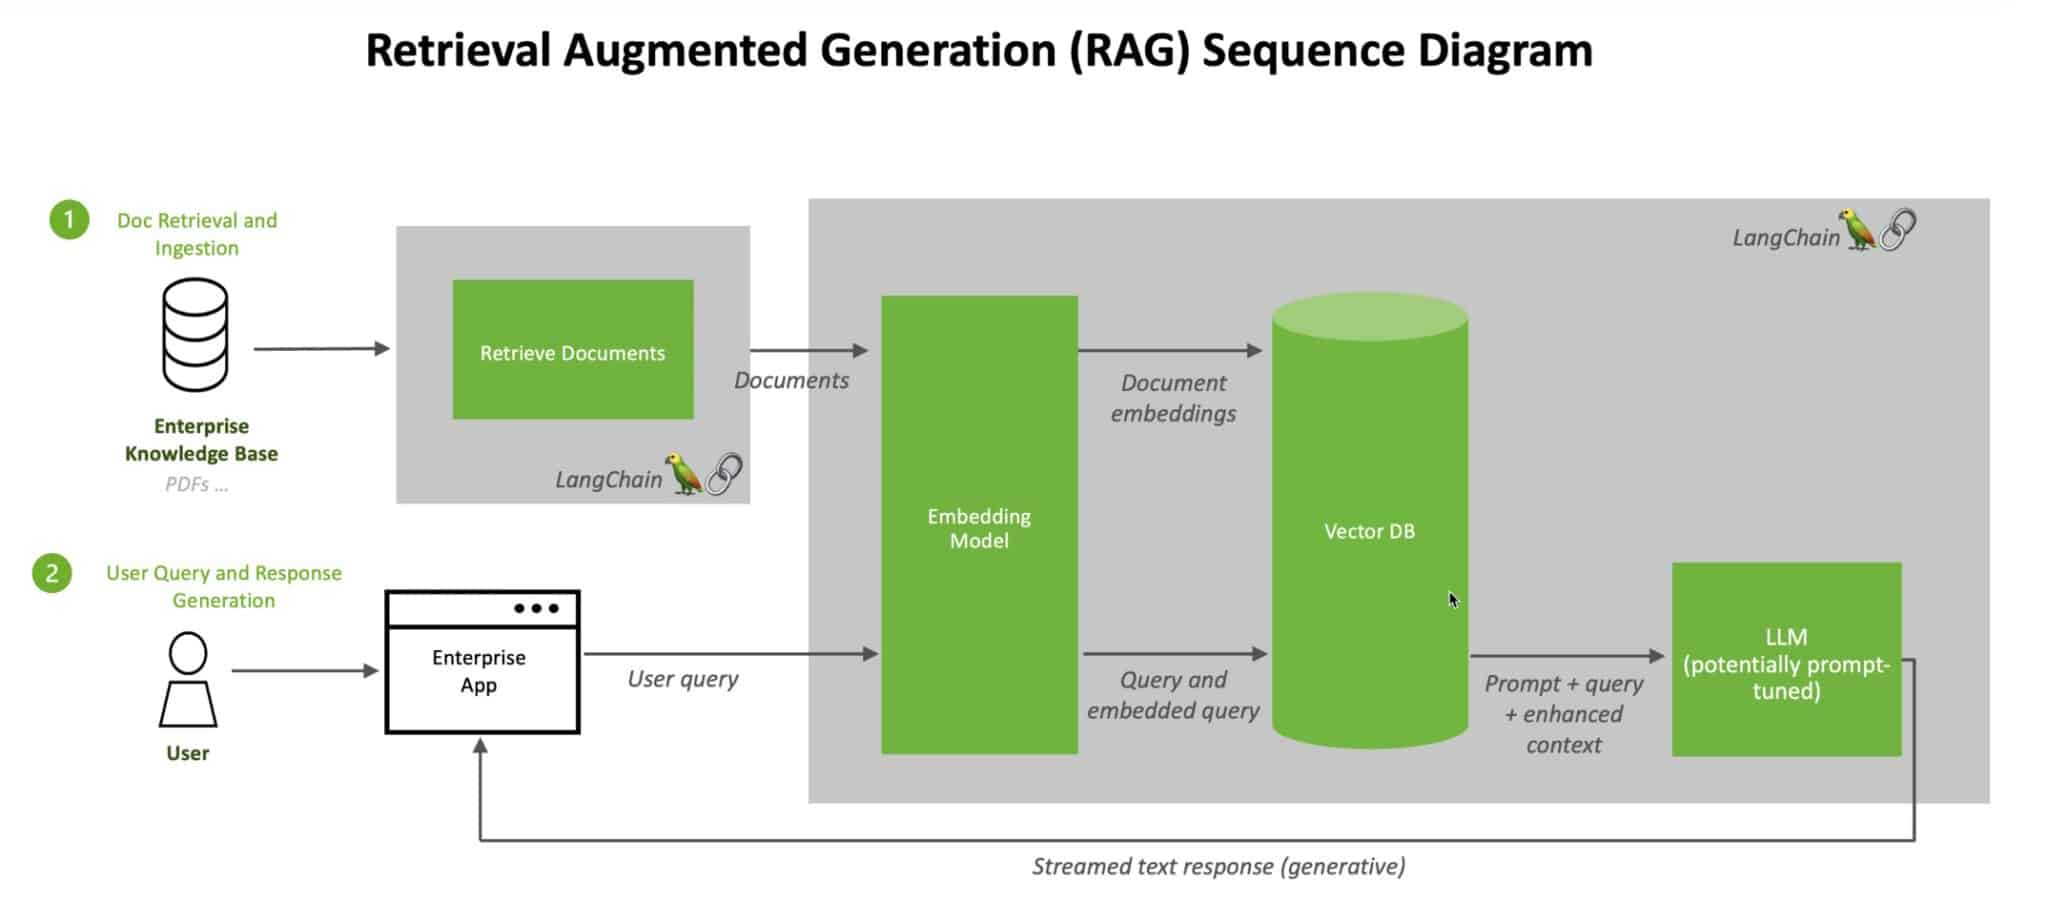

Source: https://blogs.nvidia.com/blog/what-is-retrieval-augmented-generation/

# RAG Architecture
* This is the framework that we are going to build based on Mr. Daniel Bourke's diagram:

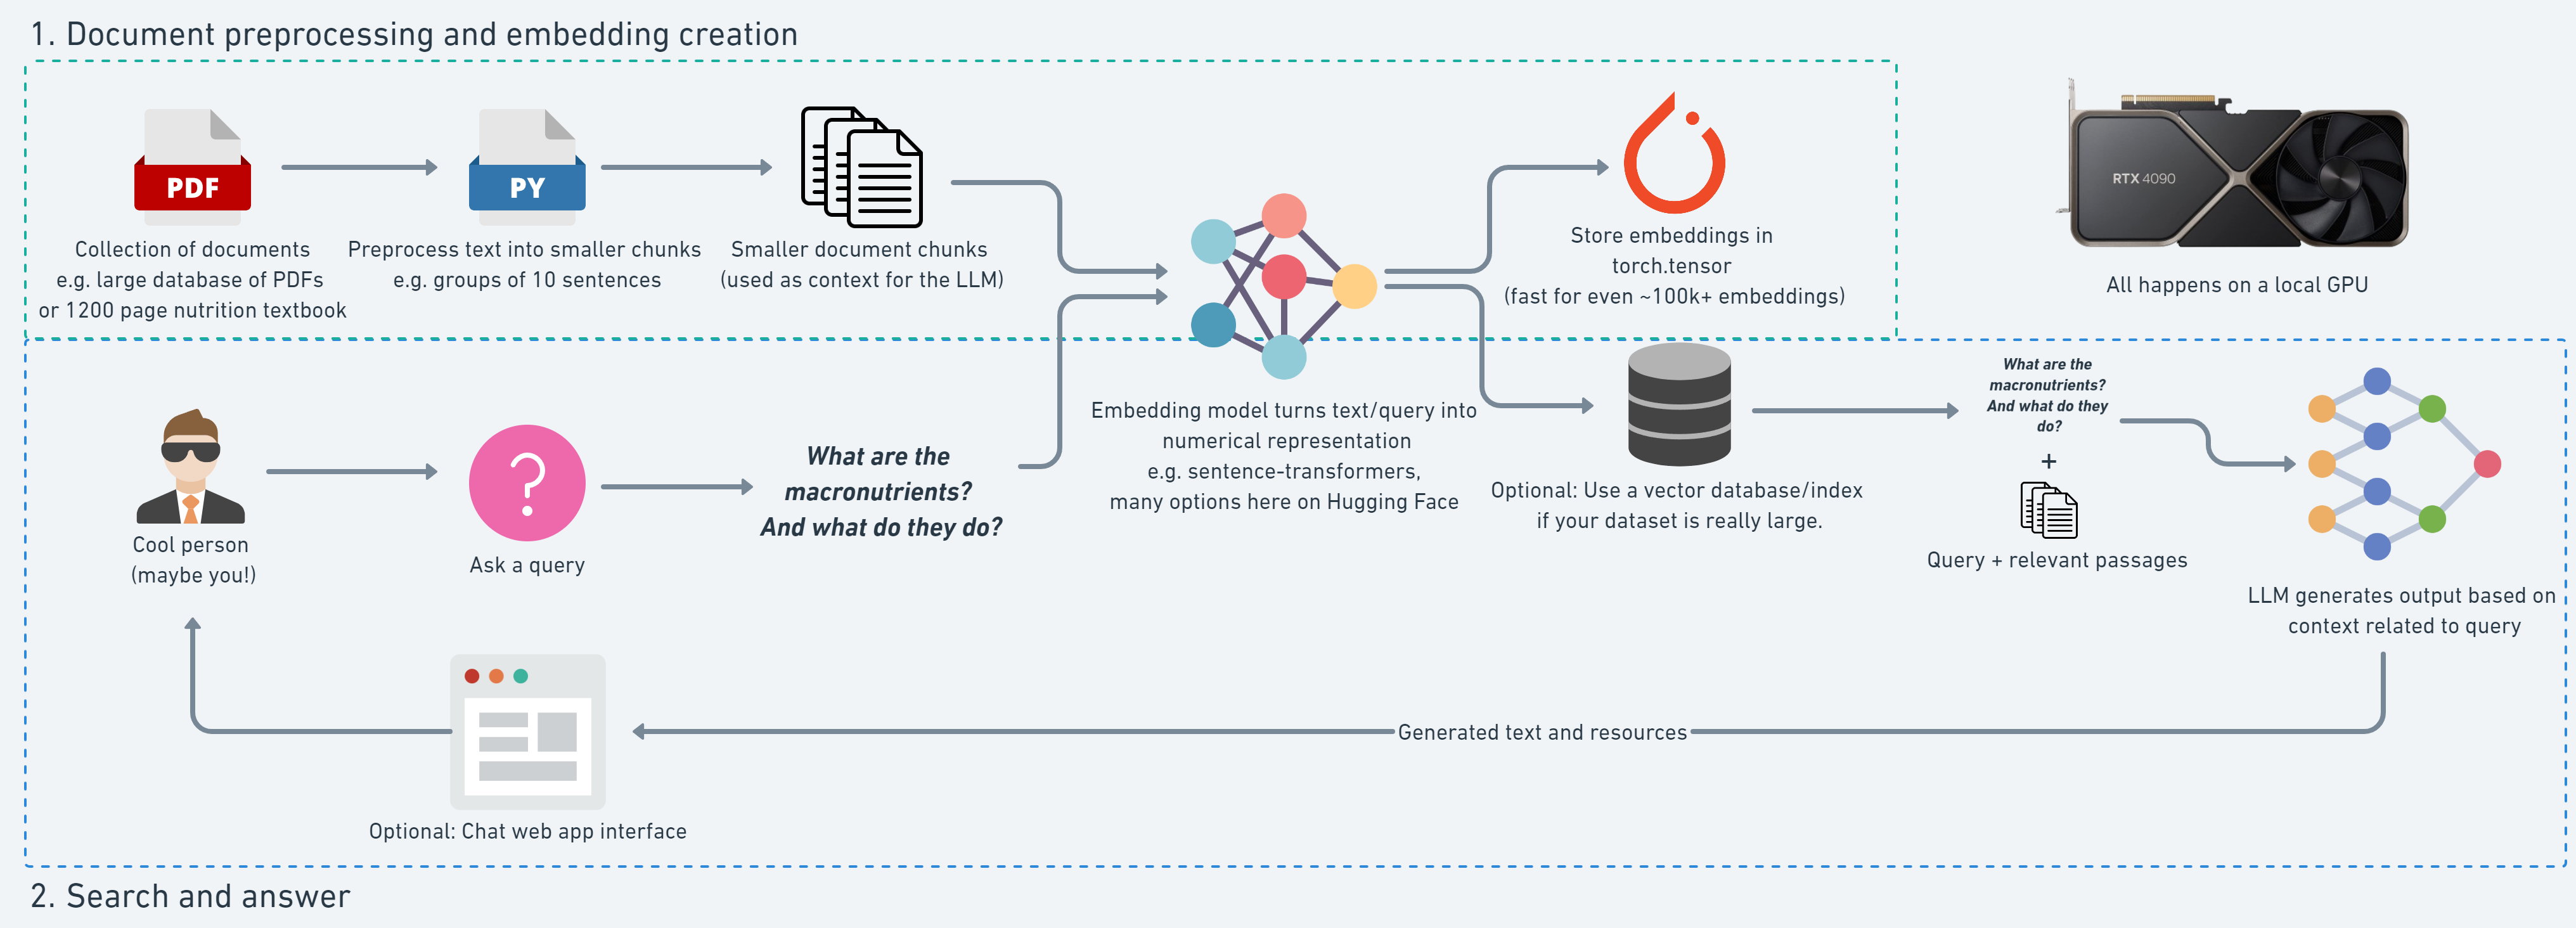

# Create and run a local RAG pipeline from Scratch

## What is RAG?
* RAG stands for Retrieval Augmented Generation.
* The goal of RAG is to take information and pass it to an LLM so it can generate outputs based on that information.

1. **Retrieval** - search or find relevant information given a query.
  * For this example we are going to take a Nutrition textbook --> encode it --> and query it.
  * An example query might be: "What are macronutrients and what do they do?"
  * The Retrieval will be the relevant fragments or passages of text semantically similar.

2. **Augmented** - we want to take the relevant information from the input prompt or query and augment the input or prompt with relevant information from an LLM.

3. **Generation** - previous 2 steps together and passing them to an LLM for generative outputs.

## Why would we want to use RAG?
* The main goal is to improve the generation outputs of the LLM.
* Using "raw" ChatGPT or the GPT API, we are only able to utilize the pre-trained model which is pre-trained on terabytes of text data from the internet.
* Thus hallucinations are more than likely due to the model's inability to generalize on information it has not seen before. Meaning it will simply "make things up" that are most similar yet not actually true or factual.
* So we use RAG to:

1. **Prevent Hallucinations** - LLMs as we know are very good at generating good *looking* text, however how do we know if this text is correct or factual?
   * Output is often *generic* but not *specific*.
   * For example, RAG can give us more *specific* outputs that are actually based on fact and accuracy.

2. **Work with custom data** - many base or pre-trained LLMs are trained on internet data.
   * Thus we know most of these are trained on "natural language" but may not be the same natural language of our specific use case(s).
   * However, it also means that a lot of responses are generic. RAG helps to create specific responses based on specific documents (e.g. your own companies customer support documents).
   * Documents can be *anything*



## What can RAG be used for?

* **Customer support Q&A chat** - treat your existing customer support documents as a resource.
   * When a customer asks a question you can immediately return fragments of text from the exact text to answer their question(s) via LLM search and processing the query and text.
   * Essentially this is a "chatbot" for your personal documents.

* **Email chain analysis** - let's say you are a large insurance company with numerous chains of emails.
   * Using a RAG pipeline you can search, retrieve, and summarize the information using an LLM.

* **Company internal documentation chat**
* **Textbook Q&A**
   * If you're a university student you could build a RAG pipeline to perform Q&A on a 1200 page textbook.

**Commmon Theme:**
* take relevant documents to a query and process them with LLM.
* Think of an LLM as a "calculator for words."

## Why local RAG pipeline?
* **Fun**
* **Privacy**
   * if you have top secret or private documentation, you don't want to send that information to a public API.
* **Speed**
   * running locally means no external data transfer.
* **Cost**
   * If you own your hardware, cost is paid!
   * API fees are non applicable.
* **No vendor lockin**
   * If you rely on OpenAI or another vendor, you can still run your business.

## What we are building
1. Document preprocessing and embedding creation
   * Textbook raw link: https://github.com/mrdbourke/simple-local-rag/blob/main/human-nutrition-text.pdf
2. Search/Query and Answer

We're building an application called "Nutrichat" to talk to a Nutrition Textbook. However, this could be *anything*.

This entire framework is based off the 2021 paper by MetaAI (Facebook)
 * Paper link: https://arxiv.org/pdf/2005.11401
 * The "Broader Impact" section of the paper really explains why this framework is important.

 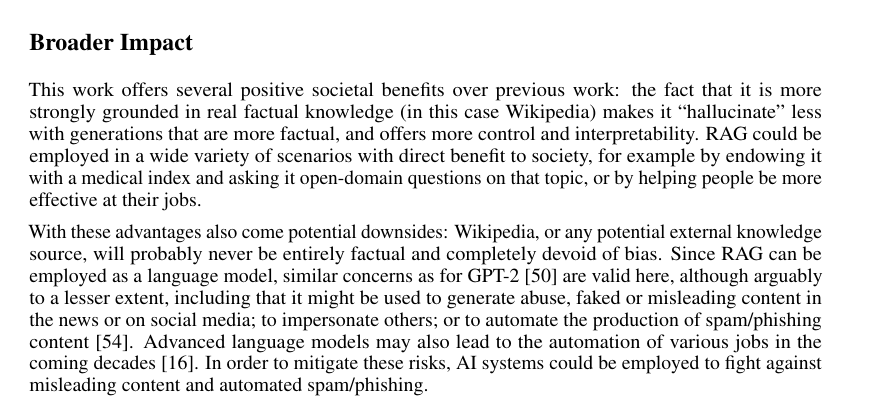

## Steps
1. Open a PDF document
  * Any PDF or document collection works.
2. Format the text of the PDF textbook.
  * chunking
3. Create embeddings
  * Vector representation of text.
4. Build retrieval system that uses vector search to find relevant semantic chunks based on a query.
5. Create prompt that incorporates the semantically retrieved text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.


### Workflow Breakdown
1. *Steps 1-3:* Document preprocessing and embedding creation.
2. *Steps 4-6:* Search/Query and Answer

## 1. Document/text processing and embedding creation

Ingredients:
* PDF documents of choice or any type of document(s).
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding
   * Split into chunks of sentences
3. Embed text chunks with embedding model
4. Save embeddings to file for later usage.

### Import PDF Document
* You can upload locally or import via requests.
* Mozilla status codes: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status

In [1]:
## imports
import os
import requests

# Get the PDF document path
pdf_path = "human-nutrition-text.pdf"

# Download PDF document from path
if not os.path.exists(pdf_path):
  print(f"[INFO] File doesn't exist, downloading....")

  # Enter URL of PDF
  url = 'https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf'

  # local filename to save downloaded file
  filename = pdf_path

  # send GET request to the URL
  response = requests.get(url)

  # check if request was successful
  if response.status_code == 200:
    # Open file and save it
    with open(filename, "wb") as file:
      file.write(response.content) #download url
    print(f"[INFO] The file has been downloaded and saved as {filename}")
  else:
    print(f"[INFO] Failed to download the file. Status code: {response.status_code}")

else:
  print(f"File {pdf_path} exists.")

[INFO] File doesn't exist, downloading....
[INFO] The file has been downloaded and saved as human-nutrition-text.pdf


### PyMuPDF
* github: https://github.com/pymupdf/PyMuPDF
* We will use this to open the PDF and for extraction.

In [2]:
# install pymupdf
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 75.6 MB/s eta 0:00:00


In [3]:
# fitz is the legacy name for PyMuPDF
import fitz #requires !pip install PyMuPDF
from tqdm.auto import tqdm #progress bars

# helper function - text formatting or "cleaning"
def text_formatter(text: str) -> str:
  """Performs text formatting/cleaning."""
  # Replace new lines with whitespace --> strip
  cleaned_text = text.replace("\n", " ").strip()

  # other formatting as needed
  return cleaned_text

# helper function - open and read pdf
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path) #open with PyMuPDF
  pages_and_texts = [] #empty list
  # iterate through docs and append to list
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    # format/clean text using function
    text = text_formatter(text=text)
    # append to list as a dict - book starts on page 41
    pages_and_texts.append({"page_number": page_number - 41,
                           "page_char_count": len(text),
                           "page_word_count": len(text.split(" ")),
                           "page_sentence_count_raw": len(text.split(". ")),
                           "page_token_count": len(text) / 4, # 1 token == 4 chars
                           "text": text})
  return pages_and_texts


In [4]:
## using the functions
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2] # reading in first 3

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

### Random Samples
* Random sampling the text documents.

In [5]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 254,
  'page_char_count': 926,
  'page_word_count': 170,
  'page_sentence_count_raw': 8,
  'page_token_count': 231.5,
  'text': 'Image by  Allison  Calabrese /  CC BY 4.0  The first stage in the breakdown of glucose is called glycolysis.  Glycolysis, or the splitting of glucose, occurs in an intricate series  of ten enzymatic-reaction steps. The second stage of glucose  breakdown occurs in the energy factory organelles, called  mitochondria. One carbon atom and two oxygen atoms are  removed, yielding more energy. The energy from these carbon  bonds is carried to another area of the mitochondria, making the  cellular energy available in a form cells can use.  Figure 4.10 Cellular Respiration  \xa0 Cellular respiration is the process by which energy is captured from  glucose.  Energy Storage  If the body already has enough energy to support its functions, the  excess glucose is stored as glycogen (the majority of which is stored  in the muscles and liver). A molecule of 

### EDA/Statistical Text Analysis
* Using pandas

In [6]:
import pandas as pd

# create dataframe
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [7]:
# stats
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.594371,198.889901,9.972682,287.148593
std,348.86387,560.441673,95.747365,6.187226,140.110418
min,-41.00000,0.000000,1.000000,1.000000,0.000000
25%,260.75000,762.750000,134.000000,4.000000,190.687500
50%,562.50000,1232.500000,215.000000,10.000000,308.125000
75%,864.25000,1605.250000,271.250000,14.000000,401.312500
max,1166.00000,2308.000000,429.000000,32.000000,577.000000


#### Why would we care about token count?

Token count is important to think about because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example, an embedding model may have been trained to embed sequences of 384 tokens into numerical space.
* We are going to use a sentence transformer model `all-mpnet-base-v2`.
* The token limit on this model is 384 (max sequence length)
  * docs: https://huggingface.co/sentence-transformers/all-mpnet-base-v2
  * SBERT docs: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html


As for LLMs, they are not able to accept infinite tokens in their context window.
* GPT-4o's token window: 128k
  * docs: https://platform.openai.com/docs/models
* Claude-3's token window: 200k
  * docs: https://www.anthropic.com/news/claude-3-family

### Additional Text pre-processing
* Two ways to do this:

1. We've done this by splitting on `". "`
2. We can do this with NLP libraries such as spaCy, NLTK or Gensim.

* Let's use spaCy `Sentencizer`
  * splits docs using rule based logic into sentences: https://spacy.io/api/sentencizer

In [8]:
## splitting text into sentences
## so we know how many sentences are on each page
from spacy.lang.en import English

# instantiate nlp object
nlp = English()

# Add sentenceizer pipeline -->
## Pipeline component for rule-based sentence boundary detection
nlp.add_pipe("sentencizer")

# create document instance
doc = nlp("This is a sentence. This is another sentence. I like kangaroos.")
assert len(list(doc.sents)) == 3

# print sentences split
list(doc.sents)

[This is a sentence., This is another sentence., I like kangaroos.]

In [9]:
# pages_and_texts
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 864,
 'page_word_count': 137,
 'page_sentence_count_raw': 8,
 'page_token_count': 216.0,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5.\xa0Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.  \xa0https:/ /ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitami

In [10]:
# loop through textbook and use sentencizer
for item in tqdm(pages_and_texts):
  item['sentences'] = list(nlp(item['text']).sents)

  # Make sure all sentences are strings (default type is a spaCy datatype)
  item['sentences'] = [str(sentence) for sentence in item['sentences']]

  # Count sentences
  item['page_sentence_count_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
## random sample pages and text
random.sample(pages_and_texts, k=1)

[{'page_number': 1068,
  'page_char_count': 631,
  'page_word_count': 121,
  'page_sentence_count_raw': 2,
  'page_token_count': 157.75,
  'text': 'Image by  272447 /  Pixabay  License  Health and Body Weight  The assumption that health is determined by body weight, or a  number on the scale, is outdated and not supported by science.\xa0 As  obesity rates continue to rise, it has been speculated that a higher  BMI stands alone as a health risk.\xa0 However, there is substantial  scientific evidence to support the notion that obesity in itself does  not put an individual at increased risk of disease.\xa0 The majority  of  epidemiological  studies  demonstrate  that  five  pounds  “underweight” is more harmful than 75 pounds “overweight”.  1068  |  Calories In Versus Calories Out',
  'sentences': ['Image by  272447 /  Pixabay  License  Health and Body Weight  The assumption that health is determined by body weight, or a  number on the scale, is outdated and not supported by science.',
  

In [12]:
## inspect this as dataframe
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking Sentences Together

The concept of splitting larger pieces of text into smaller ones is often referred to as **text splitting** or **chunking**.

There is not 100% correct way to do this.

We will keep it simple and split into groups of 10 sentences (however, you could also try 5, 6, 7, 8 or whatever you like).

You also can also use "out of the box" frameworks such as: LangChain, LlamaIndex but this example uses pure Python libraries which work just as well if you are not able to use LangChain.

#### Why do we chunk sentences together?
1. Text is easier to filter (smaller groups of text can be easier to inspect than large passages of text).
2. Text chunks can fit into our embedding model context window (e.g. 384 token limit for `all-mpnet-base-v2' SBERT model)
3. Contexts passed to an LLM can be more specific and focused for RAG.

Remember: Chunking also helps with 2 important factors when working with LLMs:
1. **Speed/Latency**: larger chunks will be slower processing time for LLMs.
2. **Cost**: larger chunks may mean more API calls to a closed source LLM like GPT.

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

## Creating a function to split lists of texts recursively into chunk size
## e.g. list of [20] --> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]: # returns list list of strings

    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]


In [14]:
## test function
test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

Summary:
* We can change the recursive overlap by adding `slice_size + x` in the return list comprehension above.

In [15]:
# loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
  item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                       slice_size=num_sentence_chunk_size)

  item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [16]:
## randomly sample sentence chunks
random.sample(pages_and_texts, k=1)

[{'page_number': 835,
  'page_char_count': 2009,
  'page_word_count': 352,
  'page_sentence_count_raw': 22,
  'page_token_count': 502.25,
  'text': '20 calories per fluid ounce, similar to breast milk, with vitamins  and minerals added. Often parents start their babies on soy formula  because they incorrectly assume that soy formula will reduce  allergies and other health problems, but this is not the case.\xa0 Soy- based formulas are sometimes given to infants who develop  diarrhea, constipation, vomiting, colic, or abdominal pain, but more  often these babies are put on hydrolysate formula to address these  concerns. Hypoallergenic protein hydrolysate formulas are given  to infants who are allergic to cow’s milk and soy protein, or who  have trouble tolerating them. This type of formula uses hydrolyzed  protein, meaning that the protein is broken down into amino acids  and small peptides, which makes it easier to digest, and makes it less  likely to trigger gastrointestinal distress.

In [17]:
## more stats on our sentence chunks
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

That will give us a good level of granularity.

This means we can dive specifically into the text sample that was used in our model.

In [18]:
import re

# splitting each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
  for sentence_chunk in item['sentence_chunks']:
    #create a chunk dictionary with chunk + page num
    chunk_dict = {}
    chunk_dict['page_number'] = item['page_number']


    # join sentences together into paragraph-like structure (join list of sentences into 1 paragraph)
    joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
    # regex: adds a space after each sentence ending
    joined_sentence_chunk = re.sub(r'\.([A-Z])', r'.\1', joined_sentence_chunk) # ".A" => ". A"

    chunk_dict['sentence_chunk'] = joined_sentence_chunk

    # stats on sent chunks
    chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
    chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4 # 1 token = 4 chars

    # append pages and chunks
    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)


  0%|          | 0/1208 [00:00<?, ?it/s]

1843

Summary:
* We now have over 1800 chunks of text.
* Let's randomly sample the text to see if we need to perform any additional text pre-processing.

In [19]:
random.sample(pages_and_texts, k=1)

[{'page_number': 751,
  'page_char_count': 1267,
  'page_word_count': 231,
  'page_sentence_count_raw': 15,
  'page_token_count': 316.75,
  'text': 'with 1 tsp. olive oil,  40  \xa0\xa0\xa0with 1 tsp. sesame seeds  18  ½ c. cooked wild rice  83  \xa0\xa0\xa0with ½ c. chopped kale  18  1 whole-wheat dinner roll  4  \xa0\xa0\xa0with 1 tsp. almond butter  33  691  (Total calories from all meals and  snacks = 1,814)  Discretionary calorie allowance: 186  (Total calories from all meals and snacks = 1,814)  Discretionary calorie allowance: 186  Healthy Eating Index  To assess whether the American diet is conforming to the Dietary  Guidelines, the Center for Nutrition Policy and Promotion (CNPP),  a division of the USDA, uses a standardized tool called the Healthy  Eating Index (HEI)2.  The first HEI was developed in 1995 and revised in 2006. This  tool is a simple scoring system of dietary components. The data for  scoring diets is taken from national surveys of particular population  subgro

In [20]:
## more stats on pages and chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,731.50,109.39,182.88
std,347.79,445.54,69.18,111.39
min,-41.00,12.00,3.00,3.00
25%,280.50,314.00,43.00,78.50
50%,586.00,745.00,111.00,186.25
75%,890.00,1112.00,168.00,278.00
max,1166.00,1824.00,290.00,456.00


In [21]:
457-384

73

Summary:
1. Max Token Count
   * We can see above that the context window of the embedding model is 384 but the max chunk token size in our sentences is 456.
   * So 457 - 384 = 73. Meaning we may miss 73 tokens in our embedding token window. This is important to consider for semantic chunking to allow the LLM to understand the chunks in context.
2. Min Token Count
   * The min token count is 3 which could also be an issue for semantic context.
   * Thus, we may want to set a minimum threshold for our chunk sizes so we don't end up with chunks/fragments with no meaning or context.

### Filter chunks of text for short chunks
* We need to create a filter to set the min chunk threshold as smaller chunks likely do not contain useful information for our use case which is a text book.
* It is important to remember that this depends on the data context. If we were looking for small contextual chunks than this may not matter, however in the context of a textbook it is important to have a minimum chunk threshold.

In [22]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,765,113,191.25
4,-36,Lifestyles and Nutrition University of Hawai‘i...,940,141,235.00


In [23]:
# show random chunks with under 30 tokens in length
# set min threshold
min_token_length = 30

for row in df[df['chunk_token_count'] <= min_token_length].sample(5).iterrows():
  print(f"Chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk token count: 10.5 | Text: Accessed November 22, 2017. 676 | Selenium
Chunk token count: 24.25 | Text: biological, chemicals, or physical) and identify preventative 1014 | Protecting the Public Health
Chunk token count: 9.75 | Text: Table 3.5 Salt Substitutes Sodium | 185
Chunk token count: 17.75 | Text: Updated July 24, 2017.Accessed April 15, 2018. 1112 | Threats to Health
Chunk token count: 11.25 | Text: Accessed March 17, 2011. 212 | Water Concerns


Summary:
* We can see most of these are hyperlinks and headings.

In [24]:
# filter our dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_length].to_dict(orient='records')
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [25]:
## lets get a random sample
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 1087,
  'sentence_chunk': 'several studies, published in the Journal of the American Medical Association 2005, did not find that dietary-fiber intake was associated with a reduction in colon cancer risk.8 There is some evidence that specific fiber types (such as inulin) may protect against colon cancer, but more studies are needed to conclusively determine how certain fiber types (and at what dose) inhibit colon cancer development. Osteoporosis There are several factors that lead to loss of bone quality during aging, including a reduction in hormone levels, decreased calcium absorption, and increased muscle deterioration.It is comparable to being charged with the task of maintaining and repairing the structure of your home without having all of the necessary materials to do so.However, you will learn that there are many ways to maximize your bone health at any age. Osteoporosis is the excessive loss of bone over time.It leads to decreased bone strength and an increased

Summary:
* We have finished pre-processing our text now.
* Yes we could have done this in a few lines of code or even using an out of the box solution from LangChain, but doing this step by step we were able to dissect the text and better understand it from a Data Science perspective.
* Text pre-processing is still an important part of LLM-RAG workflows. Although some may consider this "classical NLP", it still applies to LLMs. The old adage "garbage in-garbage out" still applies here. Remember an LLM is a deep learning model! Yes "zero-shot" learning does work but not for every use case. Therefore it is still important to understand what the NLP data is that you are working with prior to "dumping" it into an LLM-RAG pipeline.

### Embedding Text Chunks

Embeddings are a broad but powerful concept.

What we want to do:
- Turn text chunks into numbers --> embeddings.

The best part about embeddings? They are a *learned* representation of text.

We will use Sentence Transformers library: https://sbert.net/

In [26]:
# install sentence transformers
!pip install -U sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [27]:
## setup device agnostic code
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
from sentence_transformers import SentenceTransformer

# embedding model
embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device=device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [29]:
## test out the sentence transformers
sentences = ['The Sentence Transformer library provides an easy way to create embeddings.',
             'Sentences can be embeded one by one or in a list.',
             "I love birds!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# see embeddings
for sentence, embedding in embeddings_dict.items():
  print(f"Sentence: {sentence}")
  print(f"Embeddings: {embedding}")
  print("")

Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embeddings: [-3.44285630e-02  2.95328591e-02 -2.33643278e-02  5.57256751e-02
 -2.19098292e-02 -6.47057872e-03  1.02849491e-02 -6.57803565e-02
  2.29717810e-02 -2.61120535e-02  3.80421057e-02  5.61402440e-02
 -3.68746333e-02  1.52787715e-02  4.37020734e-02 -5.19723631e-02
  4.89479341e-02  3.58107197e-03 -1.29750511e-02  3.54383001e-03
  4.23261970e-02  3.52606773e-02  2.49401834e-02  2.99177319e-02
 -1.99381653e-02 -2.39752606e-02 -3.33374622e-03 -4.30450067e-02
  5.72014078e-02 -1.32517768e-02 -3.54477949e-02 -1.13936048e-02
  5.55561371e-02  3.61095252e-03  8.88527211e-07  1.14027308e-02
 -3.82229686e-02 -2.43545324e-03  1.51313748e-02 -1.32657966e-04
  5.00659905e-02 -5.50876968e-02  1.73444636e-02  5.00958823e-02
 -3.75959389e-02 -1.04463827e-02  5.08322865e-02  1.24861021e-02
  8.67376328e-02  4.64143157e-02 -2.10690182e-02 -3.90251763e-02
  1.99696166e-03 -1.42345810e-02 -1.86795164e-02  2.82669

In [30]:
# lets look at embeddings shape
embeddings[0].shape

(768,)

Summary:
* This makes sense because the embeddings are in the 768 dimensional space.

In [31]:
# testing another sentence
embedding = embedding_model.encode("My favorite animal is the horse!")
embedding

array([-9.77600459e-03,  8.12235922e-02, -2.93181576e-02, -1.77903976e-02,
        3.65883373e-02,  5.76854721e-02, -4.57921959e-02,  2.23240466e-03,
       -3.92861897e-03, -3.68127339e-02, -2.99487226e-02,  5.25926277e-02,
       -3.58384773e-02, -4.16396968e-02,  1.88470222e-02, -4.98411320e-02,
        3.66859213e-02, -1.31693622e-02, -1.14892172e-02,  4.88708615e-02,
        3.37499660e-03,  5.07520214e-02, -3.38720791e-02, -2.52422802e-02,
       -3.35427746e-03,  9.59119480e-03, -2.13153772e-02, -4.52612080e-02,
        2.68292092e-02, -1.26284931e-03, -4.73366007e-02, -7.04536811e-02,
        4.01753858e-02,  7.18948152e-03,  1.19716333e-06, -2.49808189e-02,
       -2.25218441e-02,  1.85878389e-02,  3.65071483e-02, -3.27778272e-02,
        4.14705500e-02,  1.75058395e-02, -8.79960135e-03,  9.30844340e-03,
        3.09223291e-02, -1.20087108e-02,  3.86379063e-02,  6.67351037e-02,
       -6.85986653e-02,  3.15441824e-02, -7.09488150e-03, -7.35467067e-03,
       -3.09598800e-02,  

In [32]:
# shape
embedding.shape

(768,)

In [33]:
## setup device agnostic code
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [34]:
## training our embeddings for RAG - "one by one method"
%%time

# send embeddings to device
embedding_model.to(device)

# embed each chunk one by one - using the min token length
for item in tqdm(pages_and_chunks_over_min_token_len):
  item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 1min 44s, sys: 315 ms, total: 1min 44s
Wall time: 30.3 s


Summary:
* Above we trained the embeddings "one at a time" on a GPU.
* The time was 34.4 seconds.
* **We can make this faster by training in batches.**

In [35]:
## train embeddings in batches
%%time

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 0 ns, sys: 426 µs, total: 426 µs
Wall time: 430 µs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity.The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods.Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations.Adding

In [36]:
# length of text_chunks
len(text_chunks)

1680

#### Batch Training Embeddings
* `batch_size` is a default parameter in the `.encode()` method in sentence transformers, default size is 32.
* **This will only influence the speed of training embeddings.**

In [37]:
%%time

# embed all text in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, #default size
                                               convert_to_tensor=True) #convert to pt tensors


# output embeddings
text_chunk_embeddings

CPU times: user 28 s, sys: 96.4 ms, total: 28.1 s
Wall time: 24.3 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

Summary:
* Ok a little bit faster using batches, not by much though.
* Although batching does not change the emebdding quality, it does help with speed and latency when you have larger datasets with millions of tokens to embed.

### Saving Embeddings to a file

In [38]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity.The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods.Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to

In [39]:
# save embeddings to a file - dataframe

# 1. Create a dataframe with the embeddings
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
# 2. Create a path to save the embeddings to
embeddings_df_save_path = 'text_chunks_and_embeddings_df.csv'
# 3. Save to_csv
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [40]:
## import the saved embeddings --> view them
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,765,113,191.25,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,940,141,235.00,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


Summary:
* Storing embeddings in a dataframe is not ideal and obviously not computationally efficient, thus a vector DB is obviously more ideal for storage and future use cases.

### Chunking and Embeddings - Further Details
1. Which embedding model should I use?
  * This depends on many factors. My best advice is to experiment, experiment, experiment!
  * If you want the model to run locally, you'll have to make sure it's feasible to run on your own hardware.
  * A good place to see how different models perform on a wide range of embedding tasks is the Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard.

2. What other forms of text chunking/splitting are there?
  * There are a few options out there. We've kept it simple with groups of sentences.
  * For more, Pinecone has a great guide on different kinds of chunking including for different kinds of data such as markdown and LaTeX
  * Libraries such as LangChain also have a good amount of in-built text splitting options.

3. What should I think about when creating my embeddings?
  * The sentence transfomers model we used takes text inputs up to 384 tokens long in embedding vectors of size 768.
  * Generally speaking, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).
  * Though with larger vector sizes comes larger storage and compute requirements.
  * The model used here is also relatively small (420MB) in size compared to larger models that are available open source on huggingface.
  * Larger models may result in better performance but will also require more compute.

So some things to think about:
* **Size of input** - If you need to embed longer sequences, choose a model with a larger input capacity.
* **Size of embedding vector** - Larger is generally a better representation but requires more compute/storage.
* **Size of model** - Larger models generally result in better embeddings but require more compute power/time to run.
* **Open or closed** - Open source models allow you to run them on your own hardware whereas closed source models can be easier to setup but require an API call to get embeddings.


Where should I store my embeddings?

* If you've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), `np.array` or `torch.tensor` can work just fine as your dataset.
* However, if you've got a production level system and want to work with 100,000+ embeddings, you may want to look into a **vector database**.

Document Ingestion and Embedding Creation Extensions


* One major extension to the workflow above would to functionize it.
* Or turn it into a script.
* As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).
* So you could input a document on one end and have embeddings come out the other end.

**The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results. Yes this is even true for using large language models. Classical NLP techniques still apply.**

## 2. RAG - Search and Answer

* **RAG Goal:** Retrieve relevant text passages based on our queries and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity Search

Embeddings can be used for almost any type of data.

For example, images/sound/text/etc. can all be turned into embeddings.

Comparing embeddings is known as similarity search or vector search or *semantic search*.

In this use case, we will be querying the nutrition text book chunks/passages based on *semantics*.


-----------------------------------------
**Semantic Search**: Searching for "macronutrient nutrition" will return all related passages.

**Keyword Search**: Search for "Apple" returns only "Apple" passages

In [41]:
import random
import torch
import numpy as np
import pandas as pd

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


# import text and embedding dataframe
embed_path = '/content/text_chunks_and_embeddings_df.csv'
text_chunks_and_embedding_df = pd.read_csv(embed_path)

## convert embedding column back to np.array (converted to string when saved to csv)
text_chunks_and_embedding_df['embedding'] = text_chunks_and_embedding_df['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df['embedding'].tolist(),axis=0), dtype=torch.float32).to(device)

# convert text and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient='records')


text_chunks_and_embeddings_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.06742427, 0.09022814, -0.005095489, -0.0317..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.05521564, 0.059213977, -0.016616724, -0.020..."
2,-37,Contents Preface University of Hawai‘i at Māno...,765,113,191.25,"[0.027980184, 0.033981375, -0.020642668, 0.001..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,940,141,235.00,"[0.06825669, 0.0381275, -0.008468541, -0.01813..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.03302645, -0.008497635, 0.009571596, -0.004..."


In [42]:
# embeddings shape
embeddings.shape

torch.Size([1680, 768])

Summary:
* We now have a PyTorch tensor.
* 1680 embeddings --> all size 768 dim.

#### Create Sentence Transformer model
* This is so we can start from this point rather than going through entire workflow above.

In [43]:
# create sentence transformer model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model is ready!

Let's create a small semantic search pipeline.

Goal:
* We want to use a semantic search query to retrieve relevant passages from our textbook.
* Example: "Macronutrient functions" and all related passages.

#### Steps to Build a semantic search pipeline
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between text embeddings and search query embeddings.
4. Sort results from 3 in descending order.

In [44]:
device

'cuda'

Note: To use dot product for comparison, ensure vector sizes are of same shape (e.g. 768) and tensors/vectors are in the same datatype(e.g. both are torchfloat32)

In [45]:
# 1. Define query
query = "vitamin D deficiency"
print(f"Query: {query}")

# 2. Embed the query - same embedding model as the knowledge base
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with dot product (use cosine similarity if outputs of model are not normalized)
from time import perf_counter as timer

start_time = timer()
# get dot product
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")


# 4. Get top k results (we'll keep to Top 5 results)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: vitamin D deficiency
[INFO] Time taken to get scores on 1680 embeddings: 0.02756 seconds.


torch.return_types.topk(
values=tensor([0.7719, 0.7544, 0.6762, 0.6286, 0.6006], device='cuda:0'),
indices=tensor([ 776,  778,  780,  777, 1377], device='cuda:0'))

In [46]:
# lets see the top embedding index above
pages_and_chunks[776]

{'page_number': 531,
 'sentence_chunk': 'Vitamin D’s Functional Role Activated vitamin D3 (calcitriol) regulates blood calcium levels in concert with parathyroid hormone.In the absence of an adequate intake of vitamin D, less than 15 percent of calcium is absorbed from foods or supplements.The effects of calcitriol on calcium homeostasis are critical for bone health.A deficiency of vitamin D in children causes the bone disease nutritional rickets.Rickets is very common among children in developing countries and is characterized by soft, weak, deformed bones that are exceptionally susceptible to fracture.In adults, vitamin D deficiency causes a similar disease called osteomalacia, which is characterized by low BMD.Osteomalacia has the same symptoms and consequences as osteoporosis and often coexists with osteoporosis.Vitamin D deficiency is common, especially in the elderly population, dark- skinned populations, and in the many people who live in the northern latitudes where sunlight ex

In [47]:
embeddings.dtype

torch.float32

In [48]:
query_embedding.dtype

torch.float32

### Simulating larger embeddings

In [49]:
400*750000

300000000

In [50]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# perform dot product across 168,000 embeddings - simulation
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()


print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")


Embeddings shape: torch.Size([168000, 768])
[INFO] Time taken to get scores on 168000 embeddings: 0.00094 seconds.


Summary:
* We can see that searching over embeddings is very fast, even if we do "exhaustive" or "brute force" search over EVERY embedding.
* **However, this is wasteful and computationally expensive!!!!**
* So what if you had 10 million or more embeddings?
* **An Index would be most helpful to narrow our search.**
    * An index is similar to letters in the dictionary.
    * For example, if you wanted to search "Duck" in the dictionary, you would index at D, Du, etc.
    * This obviously narrows the search very quickly and is more efficient.

* A popular indexing library for vector search is **FAISS** from Facebook AI or Meta AI.
   * **Faiss library:** https://github.com/facebookresearch/faiss
   * **ANN (one of the algorithms that FAISS uses)**: https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6

### "prettify" the vector search results
* We can use the Python library `textwrap`
* Here is some functionality: https://martinheinz.dev/blog/108

In [51]:
## helper function
import textwrap

def print_wrapped(text, wrap_length=80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

In [52]:
## let's test it out with some random text from huggingface
test_text = "The project aims to train sentence embedding models on very large sentence level datasets using a self-supervised contrastive learning objective. We used the pretrained microsoft/mpnet-base model and fine-tuned in on a 1B sentence pairs dataset. We use a contrastive learning objective: given a sentence from the pair, the model should predict which out of a set of randomly sampled other sentences, was actually paired with it in our dataset."

In [53]:
print_wrapped(test_text,20)

The project aims to
train sentence
embedding models on
very large sentence
level datasets using
a self-supervised
contrastive learning
objective. We used
the pretrained
microsoft/mpnet-base
model and fine-tuned
in on a 1B sentence
pairs dataset. We
use a contrastive
learning objective:
given a sentence
from the pair, the
model should predict
which out of a set
of randomly sampled
other sentences, was
actually paired with
it in our dataset.


In [54]:
# 1. Define query
query = "good protein sources"
print(f"Query: {query}")

# 2. Embed the query - same embedding model as the knowledge base
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with dot product (use cosine similarity if outputs of model are not normalized)
from time import perf_counter as timer

start_time = timer()
# get dot product
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")


# 4. Get top k results (we'll keep to Top 5 results)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: good protein sources
[INFO] Time taken to get scores on 1680 embeddings: 0.00018 seconds.


torch.return_types.topk(
values=tensor([0.7703, 0.7556, 0.7276, 0.7045, 0.6983], device='cuda:0'),
indices=tensor([611, 616, 617, 618, 620], device='cuda:0'))

In [55]:
## ok now lets actually use the function

print(f"Query: '{query}'\n")
print("Results:")
# loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
  print(f"Score: {score:.4f}")
  print("Text:")
  print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
  ## get page numbers and links
  print(f"Page number: {pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: 'good protein sources'

Results:
Score: 0.7703
Text:
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds.According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health.It’s the protein package that’s likely to make a
difference.”1 1. Protein: The Bottom Line.Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411


Score: 0.7556
Text:
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart
disease.Another tip is choosing to eat dry beans, peas, or soy products as a
main dish.Some of the menu choices include chili with kidney and pinto beans,
hummus on pita bread, and black bean enchiladas.You could also enjoy nuts in a
variety of ways.You 

**Note:** We could potentially improve the order of these results with a **reranking model** that has been trained to specifically take search results (e.g. top 25 semantic results) and rank them in order from most likely top 1 to least likely.

Examples of rerank model:
* Mixedbread Rerank Model: https://www.mixedbread.ai/blog/mxbai-rerank-v1
* Sentence Transformers Rerank Model: https://sbert.net/docs/pretrained-models/ce-msmarco.html

### To check our results, what if we wanted to automatically surface the page of text related to our query?

In [56]:
import fitz # pymupdf library -- option to get image of page

# open PDF and load target page
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41) # note: page numbers of our pdf start at 41+

# Get the image of the page
img = page.get_pixmap(dpi=300) ## higher dpi is higher quality of image


# save image
#img.save('output_filename.png')
doc.close()

# convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

In [57]:
img_array

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

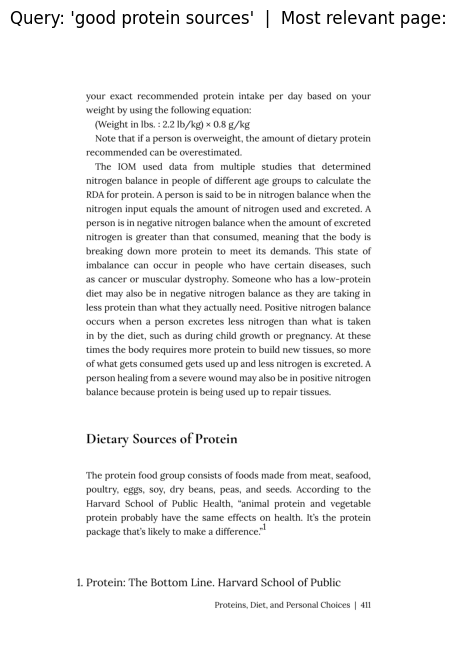

In [58]:
# display image using Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.imshow(img_array)
plt.title(f"Query: '{query}'  |  Most relevant page:")
plt.axis("off")
plt.show();

### Similarity measures: dot product and cosine similarity

* Two of the most common similarity measures between vectors are seen below.
  * The main difference between these 2? **Cosine Similarity has a normalization step!**
1. dot product
2. cosine similarity

* In essence, closer vectors have higher scores, further away vectors have lower scores.

* All of our vector embeddings have dimension of 768.

* Vectors have direction and magnitude
   * We don't program these values, the machine learning model does this!
1. Direction - which way is it going?
2. Magnitude - how long is it?



* Let's look closer at these 2 measures of similarity:

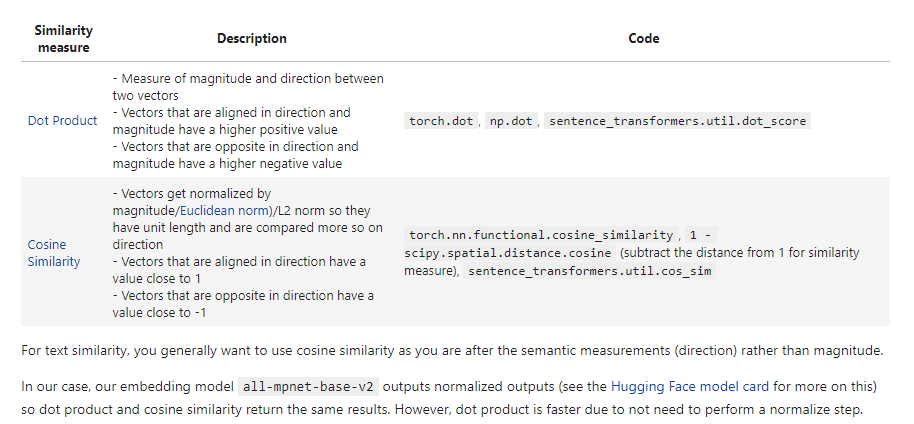

Notes:
* **Dot Product:** As mentioned above, the **dot product** uses both **magnitude and direction** between 2 vectors.
* **Cosine Similarity:**
   * Vectors are normalized by their magnitude! Thus all have the same "size".
   * Our vectors all have the magnitude (dimension) of 768.
   * Thus, cosine similarity focuses more on the **direction**


#### Why do we *mostly* use cosine similarity (direction only) with text?
* Generally speaking, in text or NLP problems, we don't worry about magnitude because the direction of the vectors is what is more important. Topic modeling is a good example, if 2 vectors are the same topic, generally they are in the same direction.
* As an example, we know that the all-mpnet-base-v2 model from huggingface says the following: **This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.**
* The model card says: ** Formally, we compute the cosine similarity from each possible sentence pairs from the batch.**
   * Source: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

* Selecting a similarity metric for comparing embeddings is not a one-size-fits-all problem. It requires a deep understanding of the properties of the embedding space, a clear definition of what constitutes similarity in the specific context, and consideration of practical constraints related to computation and scalability.
* Source: https://medium.com/@alexpodles/to-cosine-or-not-to-cosine-that-is-the-question-understanding-similarity-metrics-67ac0eb2e586

In [59]:
## lets look at an embedding
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

### Dot Product vs. Cosine Similarity in Code

In [60]:
import torch

# dot product function
def dot_product(vector1, vector2):
  return torch.dot(vector1, vector2) # returns dot product of 2 tensors


def cosine_sim(vector1, vector2):
  dot_product = torch.dot(vector1, vector2)

  # get euclidean/L2 norm
  norm_vector1 = torch.sqrt(torch.sum(vector1**2)) ## can also use torch.linalg.vector_norm
  norm_vector2 = torch.sqrt(torch.sum(vector2**2))

  return dot_product / (norm_vector1 * norm_vector2)


# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32) ## double vector 1, 2
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32) ## negatives of vector 1, 2



# calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))


Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)


Summary:
* Dot product for vector1 and vector2 is 14 which means they are most similar/aligned in direction and magnitude.
* Dot product for vector 1 and vector 3 is 32 which basically means that the magnitude is much higher which is why the value is HIGHER.
   * With cosine similarity we normalize by magnitude, so if we compute cosine similarity we may see this number drop or normalize closer to that of vector1 and vector2.
* Dot product of vector1 and vector4 is very negative which makes complete sense as they are polar opposites or inverse.


Relating this to text embeddings:
* We can see that vector 3 is twice the value or "doubly as similar" as vectors 1 and 2. This wouldn't be a problem except let's say that vector 1 is our query vector, we don't want vector3 to have the highest value, we need to thus normalize for the magnitude.

In [61]:
# calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

print("\n")

## cosine sim
print("Cosine similarity between vector1 and vector2:", cosine_sim(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_sim(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_sim(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)


Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Summary:
* Aha! Cosine similarity normalizes for the magnitude so not we can see that vector1 and vector3 when normalized is very much similar to vector 1 and vector 2!
* Vector1 and vector4 are still negative as they are negative and the inverse of vector1.
* Cosine similarity is generally favored when performing semantic search on text.
  * Cosine similarity is the dot product but it is normalized thus it becomes the cosine similarity.

**Rule of Thumb**
* If the magnitudes or L2 norm are not normalized then you need to use dot product, otherwise if normalized use cosine similarity.





### Functionizing Semantic Search Pipeline
* Function to input query --> semantic search --> output response.
* Let's put all of the steps from above for semantic search into a function so we can repeat the workflow.
  * Then we could simply import helper functions to do all this work for us.

In [62]:
## functionize pipeline
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model, # embedding model
                                n_resources_to_return: int=5, #how many passages/documents to return
                                print_time: bool=True): # keep track of time
  """
   Embeds a query with model and returns topk scores and indices from embeddings.
  """

  # Embed the query string by the user
  query_embedding = model.encode(query, convert_to_tensor=True)

  # Get dot product scores on embeddings
  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time = timer()

  if print_time:
      print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

  scores, indices = torch.topk(input=dot_scores,
                               k=n_resources_to_return)

  return scores, indices


# print top results
def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
  """
  Find relevant passages given a query and prints them out along with their scores.
  """
  scores, indices = retrieve_relevant_resources(query=query,
                                                embeddings=embeddings,
                                                n_resources_to_return=n_resources_to_return)


  # loop through zipped together scores and indices from torch.topk
  for score, idx in zip(scores, indices):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    ## get page numbers and links
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

In [63]:
# test out function
query = "foods high in fiber"
#retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (1680 embeddings: 0.00007 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye.Cellulose and lignin are insoluble fibers and a few
dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados.Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure.Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent than i

### Getting an LLM for local generation
* We want to focus on local generation for local RAG pipeline.
* However, this process also works with an LLM API (e.g. GPT)
* Two main quetions to ask:
1. Do you want to run it locally?
2. If yes, how much compute power do you have/need?

Performance
* Consider using API driven LLMs like GPT or Claude.

Open Source LLMs
* HuggingFace Leaderboard: https://huggingface.co/open-llm-leaderboard
* TheBloke on HuggingFace: https://huggingface.co/TheBloke
   * TheBloke quantizies models (compresses them).

Rule of Thumb for LLMs + Deep Learning
* Higher number of parameters ---> usually better model performance!


The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of numerical precision).

They are based on the fact that 1 float32 value (e.g. 0.69420) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

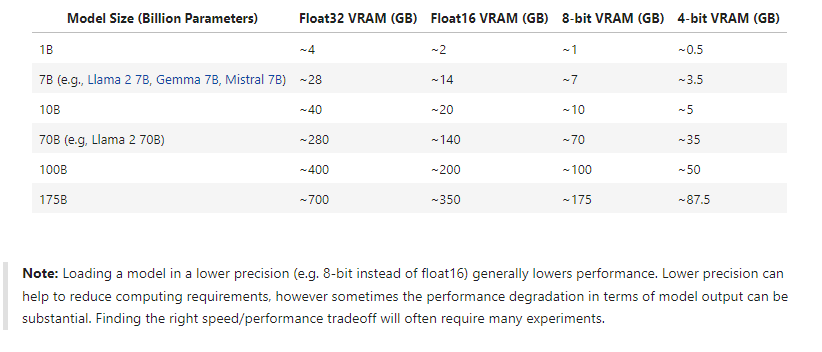

Notes:
* Loading a model in `Float32` is rare these days, most entry is `Float16`.
* 1 float32 value (e.g. 0.69420) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

Notable Open Source LLMs
* Google Gemma
* Mistral 7B
* Llama2 and Llama3
* Phi-3 (microsoft)

### Check Local GPU Memory Availability

In [64]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30)) # 4 bytes to a gig
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [65]:
!nvidia-smi

Mon Jul 15 15:25:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              31W /  70W |   2063MiB / 15360MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Notes:
* To use **gemma-7b-it** or other Gemma models, you need to use your huggingace account to accept the Gemma terms and conditions: https://huggingface.co/google/gemma-7b-it
* To download a model locally to your os and run locally from HuggingFace, you need the HuggingFace CLI: https://huggingface.co/docs/huggingface_hub/en/guides/cli

#### Gemma Model Memory

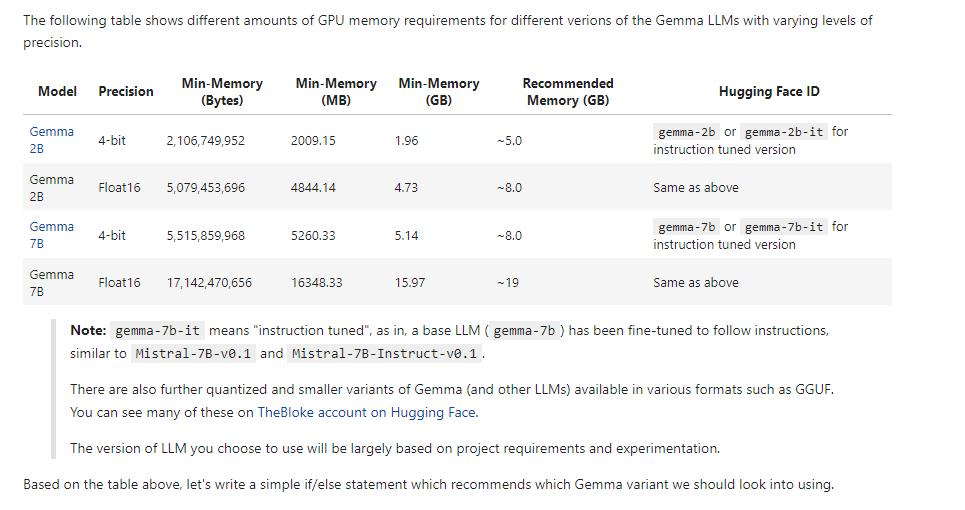

Notes:
* **IT** - "Instruction tuned" - base model was fine-tuned for instructions.

### This utility code block below will give us info on memory usage
* You can adapt this to any LLM as needed to determine the memory usage requirements for your system to run and tune an LLM locally.
* Note: I had issues accessing `google/gemma` so we will try using **Mistral-7B-Instruct-v0.1**
  * Model Card: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1

### Memory vs. GPUs
* The following code is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
* Note: Below the function `use_quantization_config` is set to `False`. This may change depending upon GPUs and memory.

In [66]:
## test out parameters vs. memory
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [67]:
!nvidia-smi

Mon Jul 15 15:25:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              31W /  70W |   2063MiB / 15360MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading an LLM Locally
* We can load an LLM locally using HuggingFace `transformers` library.
* The model we are using is (based on above):

   * GPU memory: 15
   * **Recommended model: Gemma 2B in float16 or Gemma 7B**
      * **Quantization config:** 4-bit precision
      * **use_quantization_config set to:** False
      * **model_id set to:** `google/gemma-2b-it`


To get this model running locally or on colab, we need to set a few things:
1. Quantization config (optional) - a config on what precision to load the model in (e.g. 8bit, 4bit, etc.)
2. Model ID - this tells `transformers` which model/tokenizer to load.
3. Tokenizer - turns text into numbers for LLM processing
   * note: Tokenizer is not the same as embedding model, each model has a unique tokenizer for pre-processing.
4. LLM model - this will be what we are using to generate text (generative AI) based on user input query.


> **Note:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is `flash_attn` (Flash Attention 2).
   * Flash Attention github: https://github.com/Dao-AILab/flash-attention
   * Flash Attention speeds up token processing.

In [68]:
# install bitsandbytes
!pip install -q -U bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 39.3 MB/s eta 0:00:00


In [69]:
# install langchain and langchain-community
## just in case we want to use langchain
!pip install langchain==0.2.0
!pip install langchain-community==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 210.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.7 MB/s eta 0:00:00


In [70]:
## what is device capability
torch.cuda.get_device_capability(0)[0]

7

Summary:
* To use flash_attn_2 you want > 8.

#### Model loading
* Note about loading model from HuggingFace.
* Using "gated models" requires us to use an updated huggingface token that has read permissions for "gated repositories".
  * When setting the token its also important to make sure that you accept the gated repository requirements and terms --> then generate the HF token.
  * Then store the token as a secret key in `.env` file or colab secrets.

In [71]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM # HF auto imports
from transformers.utils import is_flash_attn_2_available ## tells us if flash_attn_2 is available
from transformers import BitsAndBytesConfig #helps with quantization of the model
import accelerate
## langchain imports incase we need them
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain

### Step by Step Loading LLM and Setting Parameters
* Quantization
   * This is an excellent review of quantization parameters with BitsAndBytesConfig: https://medium.com/@rakeshrajpurohit/model-quantization-with-hugging-face-transformers-and-bitsandbytes-integration-b4c9983e8996
   * There are various hyperparams you can customize to improve the quantization which should reduce memory usage, increase speed and reduce latency.
* Flash Attention
  * GPU with 8.0 or above.
  * NVIDIA CUDA References: https://developer.nvidia.com/cuda-gpus

In [72]:
# 1. Create a quantization config
## Note: This requires !pip install bitsandbytes accelerate (see above)
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)


# Bonus: flash attention 2 = faster attention mechanisms --> speeds up transformer architecture
## Flash Attention 2 requires a GPU with a compute power of 8.0 or higher such as: hopper, ada lovelace, ampere, etc..
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa" #default: scaled dot product attention - https://pytorch.org/docs/2.2/generated/torch.nn.functional.scaled_dot_product_attention.html



In [73]:
# 2. LLM model DOWNLOAD from HuggingFace Hub (after accepting terms & conditions)
model_id = "google/gemma-2b-it"

# 3. Tokenizer instantiation (text --> tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [74]:
# 4. Model Instantation
model_4bit = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                  torch_dtype=torch.float16,
                                                  quantization_config=quantization_config if use_quantization_config else None,
                                                  low_cpu_mem_usage=False, #use as much GPU memory as we can to avoid CPU offloading
                                                  attn_implementation=attn_implementation)

# send model to target device
if not use_quantization_config:
  model_4bit.to("cuda")

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [75]:
## view model parameters
model_4bit

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [76]:
## check if using flash attn
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


Summary:
* We can see that we aren't use flash attention because in colab we don't have the compute memory/power.
* We are using the PyTorch scaled dot product (sdpa) default as defined in the model parameters.

### Get LLM Model Parameters
* We can customize getting the model parameters with a helper function.

In [77]:
## define a function
def get_model_num_params(model: torch.nn.Module):
  return sum([param.numel() for param in model.parameters()])


# use function
get_model_num_params(model_4bit)

2506172416

Summary:
* It appears that Gemma 2B is actually 2.5 billion parameters.

### Get Model Memory Size
* Another helper function to get memory size.
* Model parameters and buffer size in the model state_dict.
   * Buffers are tensors, which are registered in the module and will thus be inside the state_dict.
   * These tensors do not require gradients and are thus not registered as parameters.
* This is useful e.g. to track the mean and std in batchnorm layers etc. which should be stored and loaded using the state_dict of the module.

#### Are there built-in functions for buffer memory?
* PyTorch will create the CUDA context in the first CUDA operation, which will load the driver, kernels (native from PyTorch as well as used libraries etc.) and will take some memory overhead depending on the device.
* However, PyTorch does not report this memory which is why `torch.cuda.memory_allocated()` could return a 0 allocation.
* The best solution is to use nvidia-smi (or any other “global” reporting tool) to check the overall GPU memory usage.

In [78]:
torch.cuda.memory_allocated(model_4bit)

5985985536

In [79]:
## memory size helper function
def get_model_mem_size(model: torch.nn.Module):
  # Get model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  # Get memory buffers
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

  # calculate model sizes - how much memory the LLM is taking up locally
  model_mem_bytes = mem_params + mem_buffers
  model_mem_mb = model_mem_bytes / (1024**2) # millibytes calculation
  model_mem_gb = model_mem_bytes / (1024**3) # gigabytes calculation

  return {"model_mem_bytes": round(model_mem_bytes, 2),
          "model_mem_mb": round(model_mem_mb, 2),
          "model_mem_gb": round(model_mem_gb, 2)}


# test function
get_model_mem_size(model_4bit)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

Summary of Memory Allocation
* To load gemma-2b-it in `float16` we need a bare minimum of 4.67GB of VRAM. However, due to calculations in the forward pass of the model, we need closer to 7.67 or almost 8GB.
* It is also interesting to note the differences between our custom calculation of the model's memory allocation vs. using the built-in torch function
   * custom function: 5,012,354,048
   * PyTorch built-in function: 5,985,985,536

In [80]:
!nvidia-smi

Mon Jul 15 15:25:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0              30W /  70W |   6031MiB / 15360MiB |     30%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Generate Text with LLM (without RAG)
* We will use the "raw" LLM model to generate text based off its raw training data and zero-shot prompting just to see how it may compare to using our RAG knowledge base.

Prompt Template Specifics
* Some models are trained/tuned with specific prompt templates. This varies by model. For example, Mistral states your prompt should be surrounded by `[INST]` and `[/INST]` tokens.
* Gemma has its own chat template.

HuggingFace `apply_chat_template`
* This is a universal function that HF lets you apply to most models. Not all fit into this function and some have specific parameters.
* huggingface chat templates: https://huggingface.co/docs/transformers/main/chat_templating

In [95]:
## input query
input_text = "What are macronutrients and what are their functions in the human body?"
#print input text
print(f"Input:\n{input_text}")


# create prompt template for instruction tuned LLM
dialogue_template = [
    {"role": "user",
    "content": input_text}
]

# apply chat_template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)

# print prompt formatted
print(f"\nPrompt (formatted):\n{prompt}")

Input:
What are macronutrients and what are their functions in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are macronutrients and what are their functions in the human body?<end_of_turn>
<start_of_turn>model



In [96]:
## tokenizer we will use
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

In [97]:
## text generation
%%time

# 1. Tokenize input text --> tensors --> send to GPU
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")

#input_ids
input_ids

CPU times: user 2.06 ms, sys: 0 ns, total: 2.06 ms
Wall time: 1.46 ms


{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708, 186809, 184592,
            578,   1212,    708,   1024,   7257,    575,    573,   3515,   2971,
         235336,    107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Summary:
* Note above we have the **encoded** text or input ids with with positional encodings and **attention_masks**.
* We will now generate the **output tokens**.

In [98]:
## Now we can generate outputs from LLM
### **input_ids = input_ids + attention_masks
outputs = model_4bit.generate(**input_ids,
                              max_new_tokens=256) #given input --> generate 256 more tokens!


# print output
print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708, 186809, 184592,
           578,   1212,    708,   1024,   7257,    575,    573,   3515,   2971,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
        235303, 235256,    476,  25497,    576, 186809, 184592,    578,   1024,
          7257,    575,    573,   3515,   2971, 235292,    109,    688,  12298,
          1695, 184592,    688,    708,  37132,    674,    573,   2971,   4026,
           575,   2910,  15992,    577,  10528,   1426,   2962, 235265,   2365,
          3658,    573,   4547,  13854,    604,  29703, 235269,  29998, 235269,
           578,  44760, 235265,   2456,    708,   2149,   1872, 186809, 184592,
        235292,    109, 235287,   5231, 156615,  56227,    688,   3658,   4134,
           604,    573,   2971, 235303, 235256,   5999,    578,  29703, 235265,
          2365,    708,   1942,    575,  16512,   1582,    685,  11843, 235269,
         22512, 2

### Decoding output tokens to Text

In [99]:
## decode tokens to text
outputs_decoded = tokenizer.decode(outputs[0]) #map to text
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are macronutrients and what are their functions in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of macronutrients and their functions in the human body:

**Macronutrients** are nutrients that the body needs in large amounts to maintain good health. They provide the building blocks for tissues, organs, and enzymes. There are three main macronutrients:

* **Carbohydrates** provide energy for the body's cells and tissues. They are found in foods such as bread, pasta, rice, and potatoes.
* **Proteins** are essential for building and repairing tissues, making enzymes, and producing hormones. They are found in foods such as meat, fish, eggs, beans, and nuts.
* **Fats** provide energy, help absorb vitamins, and insulate the body. They are found in foods such as oil, butter, cheese, and nuts.

**Functions of macronutrients:**

* **Energy production:** Carbohydrates, proteins, and fats provide the body with

Summary:
* This was the raw output from the Generative AI model WITHOUT using a RAG knowledge base (the nutrition text book we ingested above).


### Augmenting input text/prompt with LLM generated and manual questions
* We can test the Gemma LLM model with LLM generated vs. manual questions.

In [101]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "What foods are high in cholesterol?",
    "What are sources of insoluble fiber?",
    "Describesymptoms of iron deficiency anemia."
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'What foods are high in cholesterol?',
 'What are sources of insoluble fiber?',
 'Describesymptoms of iron deficiency anemia.How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [102]:
import random

# randomly pick a query
query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indicies of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)


#scores, indices
scores, indices

Query: water soluble vitamins
[INFO] Time taken to get scores on (1680 embeddings: 0.00007 seconds.


(tensor([0.7893, 0.7625, 0.7386, 0.7099, 0.6996], device='cuda:0'),
 tensor([855, 801, 756, 755, 848], device='cuda:0'))

### Augmenting our prompt with context items
* So far we've done:
1. Retrieval
2. Generation

* Now its time for the last and perhaps most important step: **Augmentation!**

The concept of augmenting a prompt with contextual items is also referred to as **prompt engineering**.

Prompt Engineering is an active field of research and many new styles and techniques are still being created.
* There are a few important techniques that we know work very well.

**Resources for Prompting**
* https://www.promptingguide.ai/
* https://github.com/brexhq/prompt-engineering
* https://www.anthropic.com/news/prompt-engineering-for-business-performance

#### Prompting Techniques
1. Give clear instructions.
2. Give a few examples of input/output (e.g. given this input, i'd like this output) --> "Few-Shot prompting"
3. Give room to think such as:
   * "create a scratchpad"
   * "show your working space"
   * "let's think step by step....."


Below we will create a function to format a prompt using contextual items.

In [129]:
## create prompt formatter function
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:

    # context + join together
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # step by step technique ("Chain of Thought Prompting")
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    # Augmentation Step: update base_prompt with context + query
    base_prompt = base_prompt.format(context=context,
                                query=query)

    # Optimize prompt template for conversation for instruction-tuned model
    ## from Gemma model card conversation/dialogue guide: https://huggingface.co/google/gemma-2b-it
    dialogue_template = [
        {"role":"user",
         "content": base_prompt}
    ]

    # Apply chat_template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)


    return prompt









Basically we are using the context below fed to the LLM
* "Given this context, answer the question".

In [132]:
# test this out
query = random.choice(query_list)
print(f"Query: {query}")

# get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# format our prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)


# print prompt
print(prompt)

Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on (1680 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K

In [133]:
[item["sentence_chunk"] for item in context_items]

['Image by Allison Calabrese / CC BY 4.0 fiber intake because of what the breakdown products of the fiber do for the colon.The bacterial breakdown of fiber in the large intestine releases short-chain fatty acids.These molecules have been found to nourish colonic cells, inhibit colonic inflammation, and stimulate the immune system (thereby providing protection of the colon from harmful substances).Additionally, the bacterial indigestible fiber, mostly insoluble, increases stool bulk and softness increasing transit time in the large intestine and facilitating feces elimination.One phenomenon of consuming foods high in fiber is increased gas, since the byproducts of bacterial digestion of fiber are gases. Figure 18.2 Diverticulitis: A Disease of Fiber Deficiency Some studies have found a link between high dietary-fiber intake and a decreased risk for colon cancer.However an analysis of 1086 | Nutrition, Health and Disease',
 'Dietary fiber is categorized as either water-soluble or insolub

#### Text Generation Pipeline Setup
* We can fine tune the parameters of the `.generate()` function.
* A good resource for LLM sampling: https://huyenchip.com/2024/01/16/sampling.html
* A note about **Temperature**
   * The more deterministic we set the temp (e.g. closer to 0), the more *greedy sampling* is used and the next token
   * Temperature is used to adjust the raw logits *before* softmax transformation.
   * The more deterministic/less random, the higher the softmax probability will be fore a particular token (more predictable).
   * The more probabilistic/more random, the lower the softmax probability will be (less predictable, more random).

In [134]:
%%time

## Encode input_ids and feed to LLM
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate Output of tokens from LLM
outputs = model_4bit.generate(**input_ids,
                              temperature=0.7, # 0 is deterministic, 1 is more probabilistic/creative
                              do_sample=True, # whether or not to use sampling to choose next token
                              max_new_tokens=256) # num of new tokens to generate


# Decode output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}") # replace contextual prompt above with generated text.

Query: What role does fibre play in digestion? Name five fibre containing foods.
RAG answer:\m<bos>Sure, here is the requested information from the context:

Relevant passages:

> **Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye.Cellulose and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax, cauliflower, and avocados.Cellulose is the most abundant fiber in plants, making up the cell walls and providing structure.Soluble fibers are more easily accessible to bacterial enzymes in the large intestine so they can be broken down to a greater extent than insoluble fibers, but even some breakdown of cellulose and other insoluble fibers occurs.**

**Five fibre-containing foods:**

- Whole grains
- Peas
- Beans
- Oats
- Barley<eos>
CPU times: user 5.69 s, sys: 5.12 ms, total: 5.7 s
Wall time: 5.68 s


### Functionize LLM Response Feature
* What if we could put our RAG pipeline into 1 function?!
* Idea would be to:
1. Input query
2. Get generated output from LLM and Source documents (context) from the knowledge base (references).

Additional Notes
* Can experiment with sources of queries via different data sources, files to upload, etc..
* The `.generate()` function from huggingface can be optimized using the `Generation Config` from huggingface: https://huggingface.co/docs/transformers/en/main_classes/text_generation#transformers.GenerationConfig

In [136]:
## function for RAG pipeline

def ask_question(query: str,
                 temperature: float=0.7,
                 max_new_tokens: int=256,
                 format_answer_text=True,
                 return_answer_only=True):

    """
    Takes a query, finds relevant resources/context, generates an answer to the query based on relevant resources from knowledge base.
    """
    ## RETRIEVAL
    # Get just scores and indices of top related results --> use function from above!
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)


    # Create list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
      item["score"] = scores[i].cpu() #send to cpu

    ## AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    ## GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda") #LLM is on GPU so send prompt to GPU!

    # Generate an output of tokens
    outputs = model_4bit.generate(**input_ids,
                                  temperature=temperature,
                                  do_sample=True,
                                  max_new_tokens=max_new_tokens)


    # Decode tokens ---> Text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer -- customize format to remove padding tokens <bos>, <eos> (varies based on LLM used)
    if format_answer_text:
      # Replace prompt and special tokens
      output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos", "")

    # Only return the answer without context items
    if return_answer_only:
      return output_text

    return output_text, context_items


### Test out All-in-one Function for RAG Pipeline
* Remember the parameters we can fine tune:
1. Temperature
2. return_answer_only --> False will return context and page number/refernce from knowledge base

In [143]:
## query
query = random.choice(query_list)
print(f"Query: {query}")
ask_question(query=query,
             temperature=0.2,
             return_answer_only=False)

Query: What are sources of insoluble fiber?
[INFO] Time taken to get scores on (1680 embeddings: 0.00008 seconds.


('The passage does not provide any information about sources of insoluble fiber, so I cannot answer this question from the context.>',
 [{'page_number': 237,
   'sentence_chunk': 'Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye.Cellulose and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax, cauliflower, and avocados.Cellulose is the most abundant fiber in plants, making up the cell walls and providing structure.Soluble fibers are more easily accessible to bacterial enzymes in the large intestine so they can be broken down to a greater extent than insoluble fibers, but even some breakdown of cellulose and other insoluble fibers occurs. The last class of fiber is functional fiber.Functional fibers have been added to foods and have been shown to provide health benefits to humans.Functional fibers may be extrac

# Summary
* We built a "raw" RAG-LLM pipeline from scratch using open source models from HuggingFace.
* Evaluation Metrics, Optimization and fine tuning would be the next steps.
* We have 1 function that:
1. Runs the entire RAG-LLM pipeline and generates the answer based on the knowledge base and generates an output from a user query.
2. Also gives context of the LLM output with reference/resource.

**Other important things to remember:**
* RAG = powerful technique for text generation based on a knowledge base and/or reference documents.
* Hardware usage = use a GPU when possible to accelerate embedding creation and LLM generation.
  * Bear in mind the limitations of local hardware memory, speed, latency.
* We can experiment with multiple ways to use open source LLMs and models from huggingface.
* Vary the prompting techniques used.
* We could try re-ranking the retreival using a cross-encoder.
* We could also try using the LangChain APIs which has access to more resources.
* Vector DBs would be more ideal for using with more documents and document chunks we create.
* Optimization for speed of generation:
    * See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one
    * Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia
    * See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM
    * See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast
    * Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention

# Appendix

## Mistral 7B Instruct Code
* If you want to run a quantized Mistral 7B model. I did experiment with this as well.
* See this tutorial: https://www.youtube.com/watch?v=eovBbABk3hw
* Another resource: https://medium.com/@vishnuchirukandathramesh/how-to-run-mistral-7b-on-free-version-of-google-colab-e0effd9c6a12
* Quantization on huggingface: https://huggingface.co/docs/accelerate/en/usage_guides/quantization

In [86]:
# # 1. Create quantization config
# # Note: requires !pip install bitsandbytes, accelerate
# ## load model in 4bit but compute in float16
# quantization_config = BitsAndBytesConfig(load_in_4bit=True,
#                                          bnb_4bit_compute_dtype=torch.float16,
#                                          #bng_4bit_quant_type="nf4",
#                                          bnb_4bit_use_double_quant=True)



# ## Bonus: flash attention 2 = faster attention mechanism
# ## Flash Attention 2 requires a GPU with a compute score of 8.0+ (Ampere, Ada Lovelace, Hopper) --> https://developer.nvidia.com/cuda-gpus
# if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
#   attn_implementation = "flash_attention_2"
# else:
#   attn_implementation = "sdpa" ## scaled dot product attention -- if you dont have flash_attn_2 --> PyTorch uses sdpa by default


# # 2. Pick LLM model we want to use -- we will use Mistral-7B-Instruct
# model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# # 3. Tokenizer instantiation (transform text to tokens)
# tokenizer = AutoTokenizer.from_pretrained(model_id)

# # # 4. Model instantiation - this code would be used if we download model locally to GPU machine
# llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
#                                                    #dtype=torch.float16,
#                                                    #device_map="auto"
#                                                    quantization_config=quantization_config if use_quantization_config else None,
#                                                    low_cpu_mem_usage=False, # use as much memory as we can
#                                                    attn_implementation=attn_implementation)




# #send to target device
# if not use_quantization_config:
#   llm_model.to(device)



## Generate Text with HuggingFace Pipeline
* You can use the HF pipeline via LangChain if you follow this template:

In [87]:
# template = """<s>[INST] You are an respectful and helpful assistant, respond always be precise, assertive and politely answer in few words conversational english.
# Answer the question below from context below :
# {question} [/INST] </s>
# """

# def generate_response(question):
#   prompt = PromptTemplate(template=template, input_variables=["question","context"])
#   llm_chain = LLMChain(prompt=prompt, llm=llm)
#   response = llm_chain.run({"question":question})
#   return response

In [88]:
# ## test the model using the function

# generate_response("Name one president of america?")

# #OUTPUT
# '\nOne president of the United States is George Washington.'